In [1]:
!pip install --upgrade pip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 5.4 MB/s  0:00:00 eta 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 25.2
    Uninstalling pip-25.2:
      Successfully uninstalled pip-25.2


In [2]:
%pip install --quiet -U langchain_openai langchain_core langgraph langgraph-prebuilt langgraph-checkpoint-sqlite langchain-chroma langchain-community

Note: you may need to restart the kernel to use updated packages.


In [3]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model = "gpt-4o-mini")

/Users/shubhamprajapati/Library/Caches/pypoetry/virtualenvs/sahiloan-osalurM5-py3.13/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Basic Agent with no memory

In [4]:
from langgraph.graph import MessagesState

def assistant(state: MessagesState):
    response = llm.invoke(state["messages"])
    return {"messages": response}

In [10]:
from langgraph.graph import MessagesState, StateGraph, START, END
from IPython.display import Image, display 

workflow = StateGraph(MessagesState)
workflow.add_node("assistant", assistant)
workflow.add_edge(START, "assistant")
workflow.add_edge("assistant", END)

graph = workflow.compile()


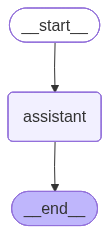

In [11]:
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [13]:
from langchain_core.messages import HumanMessage
messages = [
    HumanMessage(content="Hello, I'm Miguel!")
]

messages = graph.invoke({"messages": messages})

for m in messages['messages']:
  m.pretty_print()

================================ Human Message =================================

Hello, I'm Miguel!
================================== Ai Message ==================================

Hello, Miguel! How can I assist you today?


In [14]:
messages = [
    HumanMessage(content="Do you know my name?")
]

messages = graph.invoke({"messages": messages})
for m in messages['messages']:
  m.pretty_print()

================================ Human Message =================================

Do you know my name?
================================== Ai Message ==================================

No, I don't know your name unless you share it with me. How can I assist you today?


### With memory

In [17]:
from langgraph.checkpoint.memory import MemorySaver
checkpointer = MemorySaver()
graph_memory = workflow.compile(checkpointer=checkpointer)

In [24]:
from langchain_core.messages import HumanMessage
messages = [
    HumanMessage(content="Hello, I'm Miguel!")
]

config = {"configurable": {"thread_id": "1"}}
messages = graph_memory.invoke({"messages": messages}, config)

for m in messages['messages']:
  m.pretty_print()

================================ Human Message =================================

Hello, I'm Miguel!
================================== Ai Message ==================================

Hello, Miguel! How can I assist you today?


In [26]:
messages = [
    HumanMessage(content="Do you know my name?")
]

messages = graph_memory.invoke({"messages": messages}, config)
for m in messages['messages']:
  m.pretty_print()

================================ Human Message =================================

Hello, I'm Miguel!
================================== Ai Message ==================================

Hello, Miguel! How can I assist you today?
================================ Human Message =================================

Do you know my name?
================================== Ai Message ==================================

Yes, you mentioned that your name is Miguel. How can I help you today, Miguel?


## Agent with Summary Node

In [55]:
from langgraph.graph import MessagesState, StateGraph, START, END
from langchain_core.messages import SystemMessage, RemoveMessage

class State(MessagesState):
    summary: str

def llm_call(state: State):
    print("llm_call")
    summary = state.get("summary", "")
    messages = state["messages"]
    if summary:
        sys_message = f"Summary of conversation earlier: {summary}"
        messages.append(SystemMessage(content=sys_message)) 
    
    response = llm.invoke(messages)
    return {"messages": response}

def summary_node(state: State):
    print("summary_node")
    summary = state.get("messages", "")
    if summary:
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend this summary by taking into account the new messages above: "
        )
    else: 
        summary_message = "Create a summary of the conversation above:"

    messages = state["messages"] + [SystemMessage(content=summary_message)]
    response = llm.invoke(messages)

    ## delete all but keep the 2 latest messages
    delete_messages = [RemoveMessage(id = m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages" : delete_messages}

def should_continue(state: State):
    messages = state["messages"]
    if len(messages) > 20:
        return "summary_node"
        
    return END

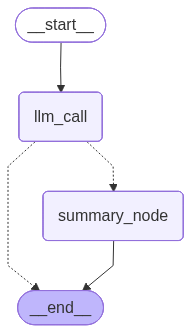

In [52]:
workflow = StateGraph(State)
workflow.add_node("llm_call", llm_call)
workflow.add_node("summary_node", summary_node)

workflow.add_edge(START, "llm_call")
workflow.add_conditional_edges(
    "llm_call",
    should_continue,
    {
        "summary_node": "summary_node",
        END: END
    }
)
workflow.add_edge("summary_node", END)

memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [53]:
# Specify a thread
config = {"configurable": {"thread_id": "44"}}

# Specify an input
messages = [HumanMessage(content="Hello, my name is Miguel!")]

# Run
messages = graph.invoke({"messages": messages},config)
for m in messages['messages']:
    m.pretty_print()

llm_call
summary:  
================================ Human Message =================================

Hello, my name is Miguel!
================================== Ai Message ==================================

Hello, Miguel! How can I assist you today?


In [54]:
messages = [HumanMessage(content="Hey, can you say my name? Do you remember it?")]

# Run
messages = graph.invoke({"messages": messages},config)
for m in messages['messages']:
    m.pretty_print()

llm_call
summary:  
================================ Human Message =================================

Hello, my name is Miguel!
================================== Ai Message ==================================

Hello, Miguel! How can I assist you today?
================================ Human Message =================================

Hey, can you say my name? Do you remember it?
================================== Ai Message ==================================

Yes, your name is Miguel! How can I help you today?


## External Memory

In [37]:
import sqlite3

# Define the path for persisting the db
db_path = "example.db"

conn = sqlite3.connect(db_path, check_same_thread=False)

from langgraph.checkpoint.sqlite import SqliteSaver

memory = SqliteSaver(conn)
graph = workflow.compile(checkpointer=memory)


In [38]:
# Specify a thread
config = {"configurable": {"thread_id": "11"}}

# Specify an input
messages = [HumanMessage(content="Hello, my name is shubham!")]

# Run
messages = graph.invoke({"messages": messages},config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Hello, my name is shubham!
================================ System Message ================================

Summary of conversation earlier: [HumanMessage(content='Hello, my name is shubham!', additional_kwargs={}, response_metadata={}, id='bc206de3-2ba1-4bfc-8cfd-56034d20fad2')]
================================== Ai Message ==================================

Hello, Shubham! How can I assist you today?


In [39]:
messages = [HumanMessage(content="Hey, can you say my name? Do you remember it?")]

# Run
messages = graph.invoke({"messages": messages},config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Hello, my name is shubham!
================================ System Message ================================

Summary of conversation earlier: [HumanMessage(content='Hello, my name is shubham!', additional_kwargs={}, response_metadata={}, id='bc206de3-2ba1-4bfc-8cfd-56034d20fad2')]
================================== Ai Message ==================================

Hello, Shubham! How can I assist you today?
================================ Human Message =================================

Hey, can you say my name? Do you remember it?
================================ System Message ================================

Summary of conversation earlier: [HumanMessage(content='Hello, my name is shubham!', additional_kwargs={}, response_metadata={}, id='bc206de3-2ba1-4bfc-8cfd-56034d20fad2'), SystemMessage(content="Summary of conversation earlier: [HumanMessage(content='Hello, my name is shubham!', additional_kwargs={